In [1]:
import cv2
import numpy as np
import os
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from keras.models import Sequential
from keras.layers import Dense,Dropout,Flatten
from tensorflow.keras.utils import to_categorical
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.utils.class_weight import compute_class_weight
import pickle
import random
from tensorflow.keras.applications import VGG16
from tensorflow.keras.optimizers import Adam

In [2]:
def augment_image(img):
    augmented_images = []

    # 1. Flip Horizontally
    # flipped = cv2.flip(img, 1)
    # augmented_images.append(flipped)

    # 2. Rotate (-30 to +30 degrees)
    angle = random.uniform(-30, 30)
    h, w = img.shape[:2]
    M = cv2.getRotationMatrix2D((w//2, h//2), angle, 1)
    rotated = cv2.warpAffine(img, M, (w, h))
    augmented_images.append(rotated)

    # 3. Adjust Brightness
    # brightness_factor = random.uniform(0.7, 1.3)
    # bright = np.clip(img * brightness_factor, 0, 255).astype(np.uint8)
    # augmented_images.append(bright)

    # 4. Add Gaussian Noise
    # noise = np.random.normal(0, 10, img.shape).astype(np.uint8)
    # noisy = cv2.add(img, noise)
    # augmented_images.append(noisy)

    return augmented_images

In [3]:
#Train Data
train_dataset_path = ["dataset/Rice_Leaf_Diease/train/bacterial_leaf_blight","dataset/Rice_Leaf_Diease/train/brown_spot","dataset/Rice_Leaf_Diease/train/healthy",
                      "dataset/Rice_Leaf_Diease/train/leaf_blast","dataset/Rice_Leaf_Diease/train/leaf_scald","dataset/Rice_Leaf_Diease/train/narrow_brown_spot",
                      "dataset/Rice_Leaf_Diease/train/neck_blast","dataset/Rice_Leaf_Diease/train/rice_hispa","dataset/Rice_Leaf_Diease/train/sheath_blight",
                      "dataset/Rice_Leaf_Diease/train/tungro"]
label = ["bacterial_leaf_blight","brown_spot","healthy","leaf_blast","leaf_scald","narrow_brown_spot","neck_blast","rice_hispa","sheath_blight","tungro",]
train_images_list = []
train_labels_list = []

for i, path in enumerate(train_dataset_path):
    if not os.path.exists(path):
        print(f"Error: Directory not found - {path}")
        continue  # Skip this folder if it doesn't exist

    dir_list = os.listdir(path)
    for img_name in dir_list:
        input_path = os.path.join(path, img_name)

        # Read image
        img = cv2.imread(input_path)
        if img is None:
            print(f"Warning: Could not read image {input_path}")
            continue  # Skip invalid images

        # Convert BGR to RGB
        img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

        # Resize to a fixed size (128x128)
        img_rgb = cv2.resize(img_rgb, (128, 128))

        # Append original image
        train_images_list.append(img_rgb)
        train_labels_list.append(label[i])

        # Apply augmentations and add to dataset
        augmented_images = augment_image(img_rgb)
        for aug_img in augmented_images:
            train_images_list.append(aug_img)
            train_labels_list.append(label[i])

# Convert lists to NumPy arrays for training
X = np.array(train_images_list)
y = np.array(train_labels_list)

print(f"Dataset size for Training: {len(X)} images")

Dataset size for Training: 30046 images


In [4]:
#Validation Data
test_dataset_path = ["dataset/Rice_Leaf_Diease/test/bacterial_leaf_blight","dataset/Rice_Leaf_Diease/test/brown_spot","dataset/Rice_Leaf_Diease/test/healthy",
                      "dataset/Rice_Leaf_Diease/test/leaf_blast","dataset/Rice_Leaf_Diease/test/leaf_scald","dataset/Rice_Leaf_Diease/test/narrow_brown_spot",
                      "dataset/Rice_Leaf_Diease/test/neck_blast","dataset/Rice_Leaf_Diease/test/Rice Hispa","dataset/Rice_Leaf_Diease/test/Sheath Blight",
                      "dataset/Rice_Leaf_Diease/test/tungro"]
# label = ["bacterial_leaf_blight","brown_spot","healthy","leaf_blast","leaf_scald","narrow_brown_spot","neck_blast","rice_hispa","sheath_blight","tungro",]
test_images_list = []
test_labels_list = []

for i, path in enumerate(test_dataset_path):
    if not os.path.exists(path):
        print(f"Error: Directory not found - {path}")
        continue  # Skip this folder if it doesn't exist

    dir_list = os.listdir(path)
    for img_name in dir_list:
        input_path = os.path.join(path, img_name)

        # Read image
        img = cv2.imread(input_path)
        if img is None:
            print(f"Warning: Could not read image {input_path}")
            continue  # Skip invalid images

        # Convert BGR to RGB
        img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

        # Resize to a fixed size (128x128)
        img_rgb = cv2.resize(img_rgb, (128, 128))

        # Append original image
        test_images_list.append(img_rgb)
        test_labels_list.append(label[i])

# Convert lists to NumPy arrays for Validation
Validation_image = np.array(test_images_list)
Validation_label = np.array(test_labels_list)

print(f"Dataset size for Validation: {len(Validation_image)} images")

Dataset size for Validation: 3422 images


In [5]:
# Generate a dictionary with images split into categories
image_label_dict = {}
for l in label:
    image_label_dict[l] = [train_images_list[i] for i, x in enumerate(train_labels_list) if x == l]

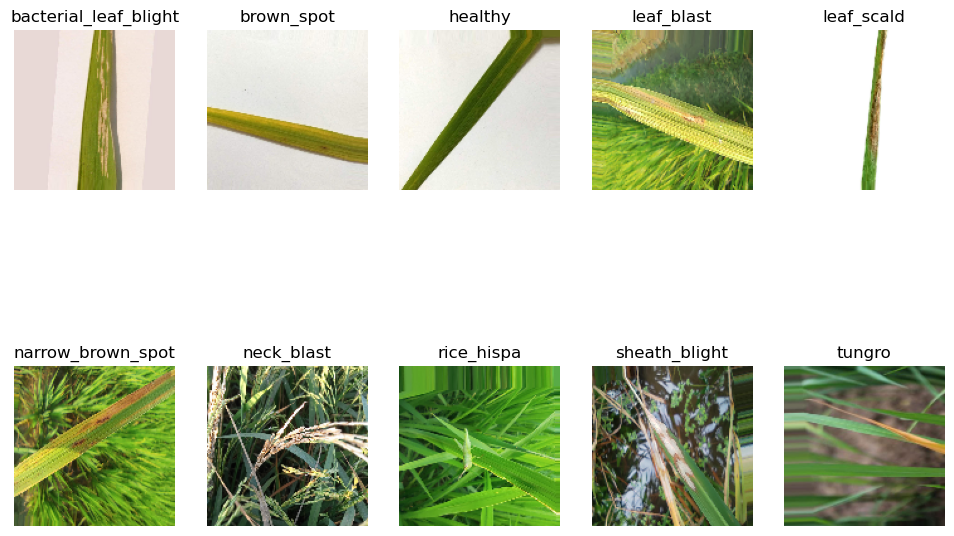

In [6]:
# Plot images
plt.figure(figsize=(12, 8))

for i, l in enumerate(label):
    if len(image_label_dict[l]) > 0:  # Ensure there's at least one image
        plt.subplot(2, 5, i + 1)
        plt.imshow(image_label_dict[l][0])
        plt.axis('off')
        plt.title(l)

plt.show()

In [7]:
print("Dictionary Keys:", image_label_dict.keys())
print("Labels List:", label)

Dictionary Keys: dict_keys(['bacterial_leaf_blight', 'brown_spot', 'healthy', 'leaf_blast', 'leaf_scald', 'narrow_brown_spot', 'neck_blast', 'rice_hispa', 'sheath_blight', 'tungro'])
Labels List: ['bacterial_leaf_blight', 'brown_spot', 'healthy', 'leaf_blast', 'leaf_scald', 'narrow_brown_spot', 'neck_blast', 'rice_hispa', 'sheath_blight', 'tungro']


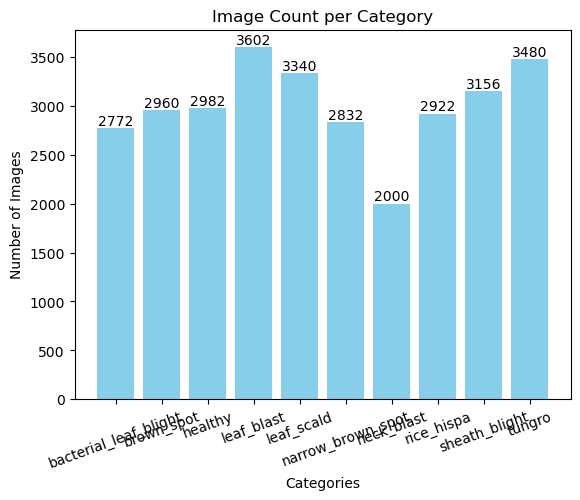

In [8]:
# Count the number of images per category
image_counts = [len(image_label_dict[l]) for l in label]

# Create bar chart
fig, ax = plt.subplots()
bars = ax.bar(label, image_counts, color='skyblue')

# Add labels on bars
ax.bar_label(bars)

# Improve visualization
ax.set_ylabel("Number of Images")
ax.set_xlabel("Categories")
ax.set_title("Image Count per Category")
plt.xticks(rotation=20)  # Rotate labels if needed
plt.show()

before Augumentation
[1584, 1440, 1600, 1308]

In [9]:
image_counts

[2772, 2960, 2982, 3602, 3340, 2832, 2000, 2922, 3156, 3480]

In [10]:
# Define class labels
classes = np.array([0, 1, 2, 3,4,5,6,7,8,9])  # Assuming 4 classes

# Define the labels for each image (list of actual class labels)
labels = np.concatenate([
    np.full(2772, 0),  # 4752 images of class 0
    np.full(2960, 1),  # 4320 images of class 1
    np.full(2982, 2),  # 4800 images of class 2
    np.full(3602, 3),   # 3924 images of class 3
    np.full(3340, 4),    #4464 images of class 4
    np.full(2832,5),
    np.full(2000,6),
    np.full(2922,7),
    np.full(3156,8),
    np.full(3480,9),
])

# Compute class weights
class_weights = compute_class_weight(class_weight='balanced', classes=classes, y=labels)

# Convert to dictionary format
class_weight_dict = {i: w for i, w in enumerate(class_weights)}

print(class_weight_dict)

{0: 1.083910533910534, 1: 1.0150675675675676, 2: 1.0075788061703554, 3: 0.8341476957245975, 4: 0.8995808383233533, 5: 1.0609463276836157, 6: 1.5023, 7: 1.028268309377139, 8: 0.9520278833967047, 9: 0.8633908045977011}


In [11]:
# Step 1: Convert to NumPy array
images_array = np.array([cv2.resize(img, (64, 64)) for img in train_images_list])  # Resize to 128x128

In [12]:
images_array = images_array / 255.0  # Normalize pixel values

In [13]:
# Step 2: Encode labels
label_encoder = LabelEncoder()
labels_encoded = label_encoder.fit_transform(train_labels_list)  # Convert text labels to numbers
labels_encoded = to_categorical(labels_encoded, num_classes= 10)

In [14]:
# Step 1: Convert to NumPy array
Validation_image = np.array([cv2.resize(img, (64, 64)) for img in Validation_image])  # Resize to 128x128


In [15]:
Validation_image = Validation_image / 255.0  # Normalize pixel values

In [16]:
# Step 2: Encode labels
label_encoder = LabelEncoder()
Validation_label = label_encoder.fit_transform(Validation_label)  # Convert text labels to numbers
Validation_label = to_categorical(Validation_label, num_classes= 10)

In [17]:
x_train, x_test, y_train, y_test = train_test_split(images_array, labels_encoded, test_size = 0.2, random_state = 42)

In [18]:
print("Length of original set: ", images_array.shape, "y:", labels_encoded.shape)
print("Length of train set: ", x_train.shape, "y:", y_train.shape)
print("Length of test set: ", x_test.shape, "y:", y_test.shape)

Length of original set:  (30046, 64, 64, 3) y: (30046, 10)
Length of train set:  (24036, 64, 64, 3) y: (24036, 10)
Length of test set:  (6010, 64, 64, 3) y: (6010, 10)


In [19]:
# Load the VGG16 model without the top layers
base_model = VGG16(weights="imagenet", include_top=False, input_shape=(64, 64, 3))

In [20]:
# Freeze the convolutional base
base_model.trainable = False

In [21]:
# Define the new model
model = Sequential()
model.add(base_model)
model.add(Flatten())
model.add(Dense(4096, activation="relu"))
model.add(Dropout(0.2))
model.add(Dense(2048, activation="relu"))
model.add(Dropout(0.2))
model.add(Dense(1024, activation="relu"))
model.add(Dropout(0.2))
model.add(Dense(10, activation="softmax"))  # 10 classes

In [22]:
# Compile the model
model.compile(optimizer=Adam(learning_rate=0.0001), loss="categorical_crossentropy", metrics=["accuracy"])

In [23]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ vgg16 (Functional)              │ (None, 2, 2, 512)      │    14,714,688 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 2048)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 4096)           │     8,392,704 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 4096)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 2048)           │     8,390,656 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 2048)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 1024)           │     2,098,176 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 1024)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 10)             │        10,250 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 33,606,474 (128.20 MB)

 Trainable params: 18,891,786 (72.07 MB)

 Non-trainable params: 14,714,688 (56.13 MB)

In [24]:
hist = model.fit(x_train, y_train, epochs=10, validation_data=(x_test, y_test), batch_size=16, class_weight=class_weight_dict)

Epoch 1/10
1503/1503 ━━━━━━━━━━━━━━━━━━━━ 1020s 668ms/step - accuracy: 0.5235 - loss: 1.3210 - val_accuracy: 0.6764 - val_loss: 0.9094
Epoch 2/10
1503/1503 ━━━━━━━━━━━━━━━━━━━━ 1003s 667ms/step - accuracy: 0.7436 - loss: 0.6872 - val_accuracy: 0.7689 - val_loss: 0.6465
Epoch 3/10
1503/1503 ━━━━━━━━━━━━━━━━━━━━ 928s 617ms/step - accuracy: 0.8028 - loss: 0.5218 - val_accuracy: 0.7975 - val_loss: 0.5503
Epoch 4/10
1503/1503 ━━━━━━━━━━━━━━━━━━━━ 928s 617ms/step - accuracy: 0.8444 - loss: 0.4101 - val_accuracy: 0.8145 - val_loss: 0.5051
Epoch 5/10
1503/1503 ━━━━━━━━━━━━━━━━━━━━ 930s 619ms/step - accuracy: 0.8689 - loss: 0.3354 - val_accuracy: 0.8236 - val_loss: 0.5002
Epoch 6/10
1503/1503 ━━━━━━━━━━━━━━━━━━━━ 923s 614ms/step - accuracy: 0.8842 - loss: 0.2924 - val_accuracy: 0.8306 - val_loss: 0.4751
Epoch 7/10
1503/1503 ━━━━━━━━━━━━━━━━━━━━ 919s 611ms/step - accuracy: 0.9008 - loss: 0.2548 - val_accuracy: 0.8459 - val_loss: 0.4650
Epoch 8/10
1503/1503 ━━━━━━━━━━━━━━━━━━━━ 927s 617ms/step - 

In [25]:
loss, acc = model.evaluate(x_test, y_test)
print(f"Test Accuracy: {acc * 100:.2f}%")
print(f"loss: {loss * 100:.2f}%")

188/188 ━━━━━━━━━━━━━━━━━━━━ 133s 705ms/step - accuracy: 0.8801 - loss: 0.3741
Test Accuracy: 87.74%
loss: 37.33%


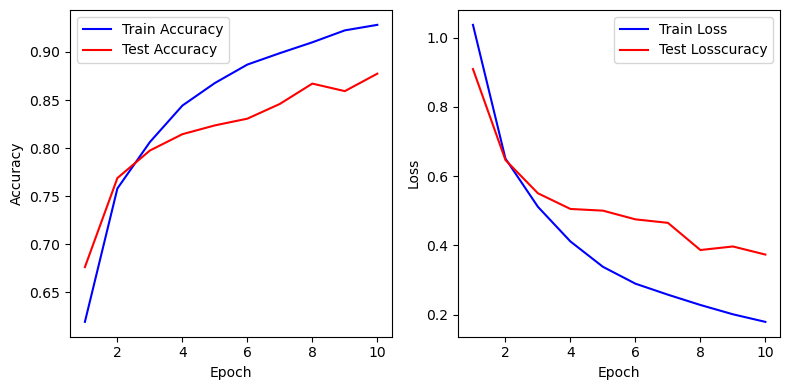

In [26]:
acc = hist.history['accuracy']
val_acc = hist.history['val_accuracy']
loss = hist.history['loss']
val_loss = hist.history['val_loss']

epochs = range(1,len(acc) + 1)
#Creating subplots
fig,axes = plt.subplots(nrows = 1, ncols = 2, figsize = (8,4))
axes[0].plot(epochs, acc, 'b', label = 'Train Accuracy')
axes[0].plot(epochs, val_acc, 'r', label = 'Test Accuracy')
axes[0].set_xlabel('Epoch')
axes[0].set_ylabel('Accuracy')
axes[0].legend()

axes[1].plot(epochs, loss, 'b', label = 'Train Loss')
axes[1].plot(epochs, val_loss, 'r', label = 'Test Losscuracy')
axes[1].set_xlabel('Epoch')
axes[1].set_ylabel('Loss')
axes[1].legend()

#Adjust layout for better spacing
plt.tight_layout()
#display figure
plt.show()

In [27]:
y_pred = model.predict(x_test)

188/188 ━━━━━━━━━━━━━━━━━━━━ 136s 720ms/step


In [28]:
y_test = np.argmax(y_test, axis=1)
y_pred = np.argmax(y_pred, axis=1)
report = classification_report(y_test,y_pred)
print(report)

              precision    recall  f1-score   support

           0       0.96      0.94      0.95       525
           1       0.83      0.70      0.76       612
           2       0.89      0.73      0.80       586
           3       0.74      0.82      0.78       735
           4       0.86      0.96      0.91       717
           5       0.81      0.82      0.81       545
           6       0.99      0.99      0.99       365
           7       0.95      0.94      0.94       574
           8       0.87      0.93      0.90       684
           9       0.98      0.96      0.97       667

    accuracy                           0.88      6010
   macro avg       0.89      0.88      0.88      6010
weighted avg       0.88      0.88      0.88      6010



In [29]:
print(confusion_matrix(y_pred,y_test))

[[491   7   4   3   2   5   1   0   0   0]
 [  1 430  25  42   0  14   1   0   1   2]
 [  0  17 430  26   1   1   0   9   1   0]
 [  2  76  83 606  10  25   0   5   5   6]
 [ 22   5  16  16 688  21   0   8  17   8]
 [  2  71   6  16   3 446   0   1   8   0]
 [  0   1   0   0   0   1 363   0   1   0]
 [  0   2  10   1   4   3   0 539   8   3]
 [  7   2  10  24   9  25   0  11 638   6]
 [  0   1   2   1   0   4   0   1   5 642]]


In [30]:
val_loss, val_acc = model.evaluate(Validation_image, Validation_label)
print(f"Test Accuracy: {val_acc * 100:.2f}%")
print(f"loss: {val_loss * 100:.2f}%")

107/107 ━━━━━━━━━━━━━━━━━━━━ 80s 753ms/step - accuracy: 0.8301 - loss: 0.6717
Test Accuracy: 82.03%
loss: 84.76%


In [31]:
val_y_pred = model.predict(Validation_image)

107/107 ━━━━━━━━━━━━━━━━━━━━ 77s 715ms/step


In [32]:
val_y_test = np.argmax(Validation_label, axis=1)
val_y_pred = np.argmax(val_y_pred, axis=1)
val_report = classification_report(val_y_test,val_y_pred)
print(val_report)

              precision    recall  f1-score   support

           0       0.95      0.94      0.95       376
           1       0.77      0.76      0.76       380
           2       0.91      0.65      0.76       391
           3       0.70      0.80      0.74       362
           4       0.89      0.92      0.90       386
           5       0.84      0.88      0.86       382
           6       1.00      1.00      1.00       322
           7       0.75      0.52      0.62       225
           8       0.62      0.65      0.63       288
           9       0.76      0.98      0.86       310

    accuracy                           0.82      3422
   macro avg       0.82      0.81      0.81      3422
weighted avg       0.83      0.82      0.82      3422



In [33]:
print(confusion_matrix(val_y_pred,val_y_test))

[[355   9   1   1   0   1   0   0   5   0]
 [  5 289  39  32   0   9   0   0   2   0]
 [  1   2 253   7   0   1   0  10   3   2]
 [  2  26  57 288   3  13   0   8  14   2]
 [  9   3   1   6 354   6   0   2  15   1]
 [  1  39   4   8   3 337   0   7   4   0]
 [  0   0   0   0   0   0 322   0   0   0]
 [  0   1   7   2   5   1   0 118  24   0]
 [  3   5  18  16  15  10   0  48 186   0]
 [  0   6  11   2   6   4   0  32  35 305]]


In [34]:
pickle_out = open("modelv11.pkl", "wb")
pickle.dump(model, pickle_out)
pickle_out.close()